In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Open the GeoTIFF file
with rasterio.open("tif/n47_e015_1arc_v3.tif") as dataset:

    # Read the raster data into a NumPy array
    raster = dataset.read(1)

    # Convert the data type to float and set nodata values to NaN
    raster = raster.astype(float)
    raster[raster == dataset.nodata] = np.nan

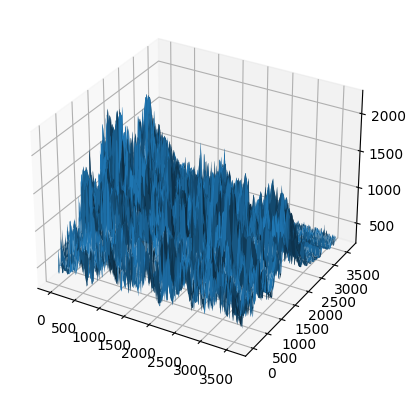

In [5]:
# Get a 10% sample of the array
sampled_raster = raster

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the x, y, and z coordinates
x, y = np.meshgrid(np.arange(sampled_raster.shape[1]), np.arange(sampled_raster.shape[0]))
z = sampled_raster

# Plot the surface
ax.plot_surface(x, y, z)

# Show the plot
plt.show()

(3601, 3601)


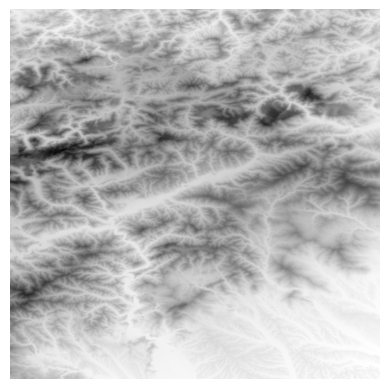

AttributeError: module 'matplotlib.pyplot' has no attribute 'savefi'

In [7]:
#Normalize the grid 
raster_norm = (raster - np.nanmin(raster)) / (np.nanmax(raster) - np.nanmin(raster))
print(raster_norm.shape)

# Plot the array in grayscale
plt.imshow(raster_norm, cmap='gray_r')
plt.axis('off')

# Show the plot
plt.show()
plt.savefi('../plot/dataset_example.png')

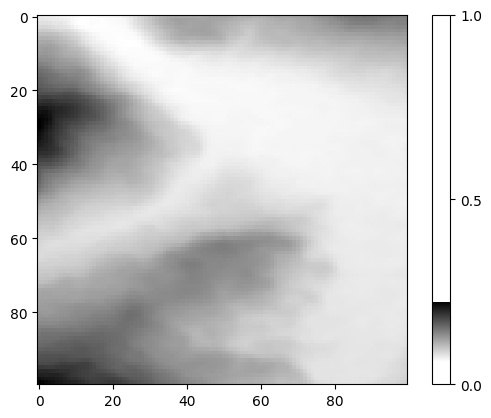

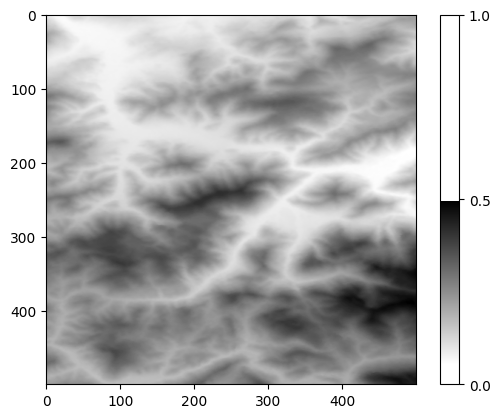

In [27]:
def gradient(grid, i, j):

    val = grid[i][j]
    s = abs(grid[i-1][j-1] - val) + abs(grid[i+1][j-1] - val) + abs(grid[i-1][j+1] - val) + abs(grid[i-1][j+1] - val)

    return s/4

# We generate the non-feasible path
def non_feasible_points(grid):
    rows = grid.shape[0]
    cols = grid.shape[1]

    for i in range(rows):
        for j in range(cols):

            if i > 0 and i + 1 < rows and j > 0 and j + 1 < cols:

                # print(gradient(grid,i,j))

                if gradient(grid, i, j) > 0.6:

                    grid[i][j] = 1.0

    # Plot the array in grayscale
    plt.imshow(grid, cmap='gray_r')
    
    rows = grid.shape[0]
    cols = grid.shape[1]

    # for i in range(rows):
    #     for j in range(cols):
    #         if grid[i][j] == 1:
    #             plt.plot(i, j, 'rD')

    cbar = plt.colorbar()
    cbar.set_ticks([0, 0.5, 1])
    plt.show()

plt.imshow(raster_norm[:100, :100], cmap='gray_r') 
cbar = plt.colorbar()
cbar.set_ticks([0, 0.5, 1])  
plt.show()
non_feasible_points(raster_norm[:500, :500])

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
import heapq
import rasterio

# Open the GeoTIFF file
with rasterio.open("tif/n47_e008_1arc_v3.tif") as dataset:
    # Read the raster data into a NumPy array
    raster = dataset.read(1)

    # Convert the data type to float and set nodata values to NaN
    raster = raster.astype(float)
    raster[raster == dataset.nodata] = np.nan

# Normalize the raster
raster_norm = (raster - np.nanmin(raster)) / (np.nanmax(raster) - np.nanmin(raster))

# Define the distance function
def euclidean_distance(a, b):
    return distance.euclidean(a, b)

def get_neighbors(node, height, width):
    
    row, col = node
    neighbors = []
    if row > 0:
        neighbors.append((row-1, col))
    if row < height-1:
        neighbors.append((row+1, col))
    if col > 0:
        neighbors.append((row, col-1))
    if col < width-1:
        neighbors.append((row, col+1))
    return neighbors

def get_weight(node1, node2, grid):
    return abs(grid[node1] - grid[node2])

def dijkstra(grid, start, end):
    # Get the dimensions of the grid
    height, width = grid.shape

    # Initialize the distances to infinity
    distances = np.full((height, width), np.inf)

    # Set the distance to the start node to 0
    distances[start] = 0

    # Initialize the priority queue with the start node
    pq = [(0, start)]

    # Initialize the previous nodes to None
    prev = np.full((height, width), None)

    # While the priority queue is not empty
    while pq:
        # Get the node with the smallest distance
        current_dist, current_node = heapq.heappop(pq)

        # If we have reached the end node, stop
        if current_node == end:
            break

        # For each neighbor of the current node
        for neighbor in get_neighbors(current_node, height, width):
            # Calculate the distance to the neighbor
            neighbor_dist = distances[current_node] + get_weight(current_node, neighbor, grid)

            # If the new distance is shorter than the old distance
            if neighbor_dist < distances[neighbor]:
                # Update the distance and previous node
                distances[neighbor] = neighbor_dist
                prev[neighbor] = current_node

                # Add the neighbor to the priority queue
                heapq.heappush(pq, (neighbor_dist, neighbor))

    # Backtrack from the end node to the start node to get the path
    path = [end]
    current_node = end
    while current_node != start:
        current_node = prev[current_node]
        path.append(current_node)
    path.reverse()

    return path

from queue import PriorityQueue

def a_star(grid, start, end):
    """
    Perform A* algorithm to find the shortest path between start and end nodes in a grid.
    """
    height, width = grid.shape
    
    # Define a function to calculate the heuristic value
    def heuristic(node):
        return np.sqrt((node[0] - end[0]) ** 2 + (node[1] - end[1]) ** 2)

    # Initialize the starting node and the priority queue
    start_node = (start, 0)
    queue = PriorityQueue()
    queue.put(start_node)

    # Initialize the visited set and the parent dictionary
    visited = set()
    parent = {}

    # Initialize the distance and cost dictionaries
    distance = {start: 0}
    cost = {start: heuristic(start)}

    # Process the nodes in the priority queue
    while not queue.empty():
        # Get the node with the lowest cost
        current_node = queue.get()[1]

        # Check if the current node is the end node
        if current_node == end:
            # Reconstruct the path and return it
            path = []
            while current_node in parent:
                path.append(current_node)
                current_node = parent[current_node]
            path.append(start)
            path.reverse()
            return path

        # Add the current node to the visited set
        visited.add(current_node)

        # Process the neighbors of the current node
        for neighbor in get_neighbors(grid, current_node, width):
            # Calculate the tentative distance to the neighbor
            tentative_distance = distance[current_node] + grid[neighbor]

            # Check if the neighbor has not been visited or the tentative distance is less than the recorded distance
            if neighbor not in visited or tentative_distance < distance[neighbor]:
                # Update the parent and distance dictionaries
                parent[neighbor] = current_node
                distance[neighbor] = tentative_distance

                # Calculate the cost of the neighbor and add it to the priority queue
                cost[neighbor] = tentative_distance + heuristic(neighbor)
                queue.put((cost[neighbor], neighbor))

    # No path found
    return None


In [97]:
# Generate a graph
import networkx as nx

def generate_graph(raster):

    G = nx.Graph()
    # Add nodes to the graph for each cell in the raster
    rows, cols = raster.shape
    for i in range(rows):
        for j in range(cols):
            G.add_node((i, j))

    # Add edges to the graph with weights based on the values of adjacent cells
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                weight = raster[i, j+1]
                G.add_edge((i, j), (i, j+1), weight=weight)
            if i < rows - 1:
                weight = raster[i+1, j]
                G.add_edge((i, j), (i+1, j), weight=weight)
            if i < rows - 1 and j < cols - 1:
                weight = raster[i+1, j+1]
                G.add_edge((i, j), (i+1, j+1), weight=weight)
            if i < rows - 1 and j > 0:
                weight = raster[i+1, j-1]
                G.add_edge((i, j), (i+1, j-1), weight=weight)

    # # Plot the graph
    # pos = {node: node for node in G.nodes()}
    # nx.draw(G, pos=pos, node_size=1)

    # print(nx.info(G))

    return G

In [96]:

# Define the start and end points
start = (2, 3)
end = (5, 8)

raster_norm = raster_norm[:10, :10]

# Get the path using Dijkstra's algorithm
graph = {}
for i in range(raster_norm.shape[0]):
    for j in range(raster_norm.shape[1]):
        if not np.isnan(raster_norm[i][j]):
            if i > 0 and not np.isnan(raster_norm[i-1][j]):
                graph[(i, j)] = graph.get((i, j), {}) 
                graph[(i, j)][(i-1, j)] = euclidean_distance((i, j), (i-1, j)) * raster_norm[i-1][j]
            if i < raster_norm.shape[0] - 1 and not np.isnan(raster_norm[i+1][j]):
                graph[(i, j)] = graph.get((i, j), {})
                graph[(i, j)][(i+1, j)] = euclidean_distance((i, j), (i+1, j)) * raster_norm[i+1][j]
            if j > 0 and not np.isnan(raster_norm[i][j-1]):
                graph[(i, j)] = graph.get((i, j), {})
                graph[(i, j)][(i, j-1)] = euclidean_distance((i, j), (i, j-1)) * raster_norm[i][j-1]
            if j < raster_norm.shape[1] - 1 and not np.isnan(raster_norm[i][j+1]):
                graph[(i, j)] = graph.get((i, j), {})
                graph[(i, j)][(i, j+1)] = euclidean_distance

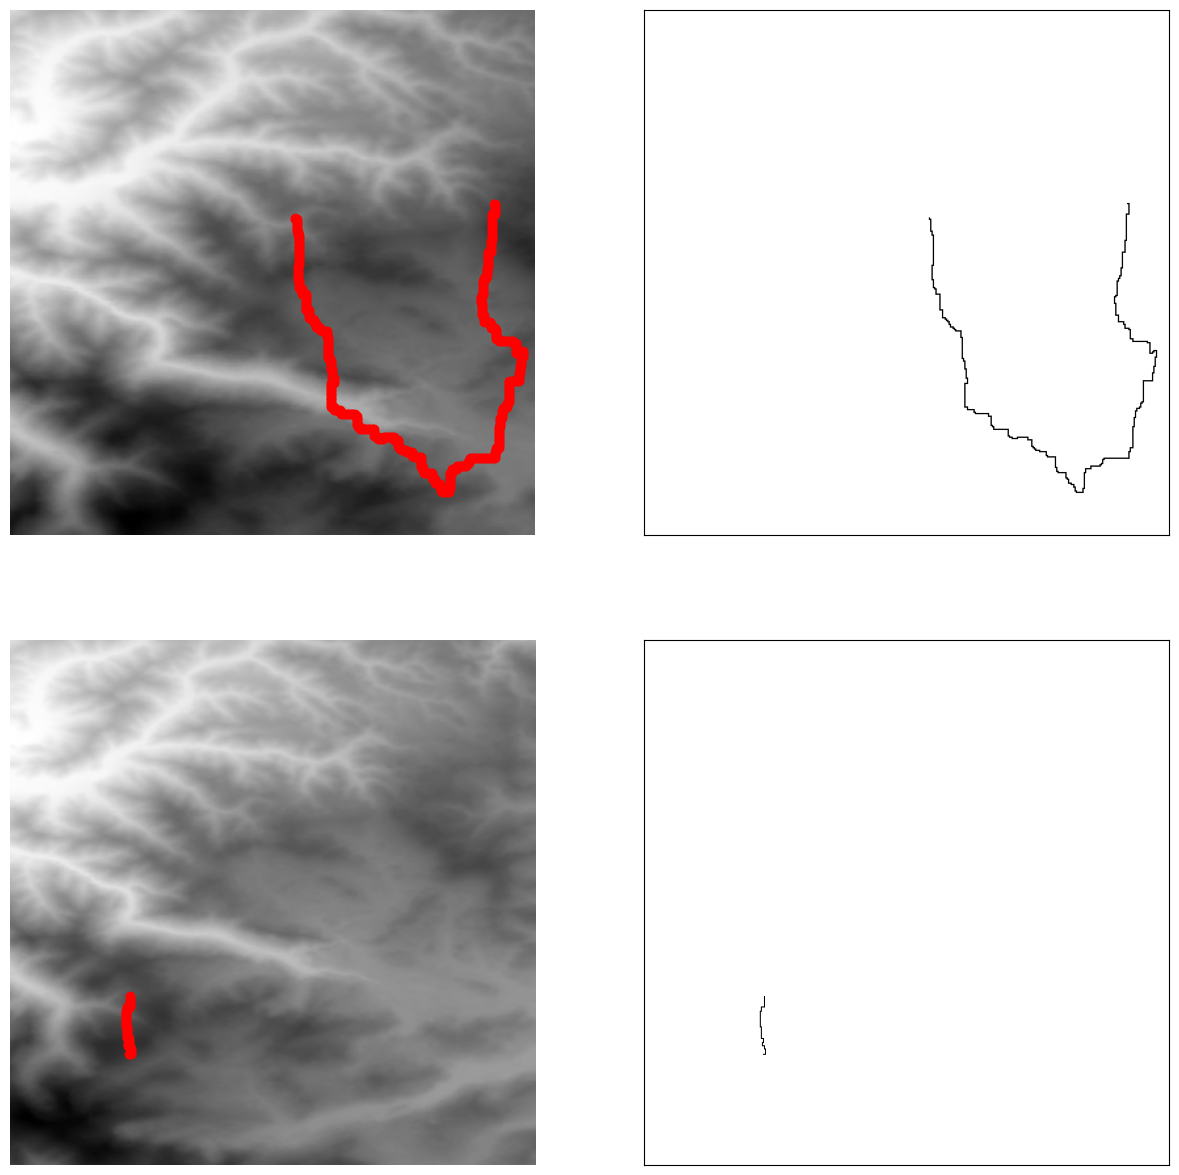

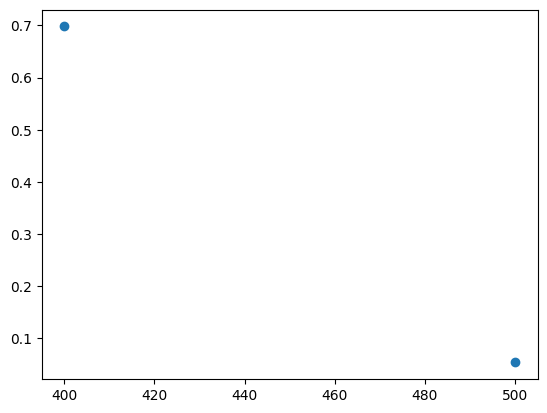

In [16]:
# Open the GeoTIFF file
import random
import time
import matplotlib.pyplot as plt

range_size = [400, 500]
times = []
fig, ax = plt.subplots(ncols=len(range_size), nrows = 2, figsize = (15,15))

for i in range(len(range_size)):
    with rasterio.open("tif/n47_e008_1arc_v3.tif") as dataset:    

        max_range = range_size[i]

        # Read the raster data into a NumPy array
        raster = dataset.read(1)

        # Convert the data type to float and set nodata values to NaN
        raster = raster.astype(float)
        raster[raster == dataset.nodata] = np.nan

        # Normalize the raster
        raster_norm = (raster - np.nanmin(raster)) / (np.nanmax(raster) - np.nanmin(raster))

        # Define the start and end points
        start = (random.randint(0, max_range-1), random.randint(0, max_range-1))
        end = (random.randint(0, max_range-1), random.randint(0, max_range-1))

        raster_norm = raster_norm[:max_range, :max_range]

        # Run Dijkstra's algorithm
        start_time = time.time()
        path_dijkstra = dijkstra(raster_norm, start, end)
        # path_a_star = a_star(raster_norm, start, end)

        times.append(time.time() - start_time)

        # Plot the normalized raster
        ax[i,0].imshow(raster_norm, cmap='gray_r')
        ax[i,0].axis('off')

        # Plot the label grid
        label_grid = np.zeros((max_range, max_range))

        # Plot the path
        for cell in path_dijkstra:
            x, y = cell
            ax[i,0].plot(x, y, 'ro')
            label_grid[y][x] = 1

        ax[i,1].imshow(label_grid, cmap='gray_r')
        ax[i,1].tick_params(axis='both', which='both', labelbottom=False, labelleft=False, length=0)

# Show the plot
plt.savefig('../plot/djikstra_example.png')
plt.show()

plt.scatter(range_size, times)
plt.savefig('computation_time.png')

plt.show()

In [4]:
# We cut the graph in 100*100 sections : 1296 grids per initial grid

import numpy as np

# Create a random 3601x3601 grid for testing purposes
original_grid = raster_norm

# Determine the number of 100x100 grids that can fit within the original grid
num_horizontal_grids = original_grid.shape[1] // 100
num_vertical_grids = original_grid.shape[0] // 100

# Create a list to store the 100x100 grids
grids = []

# Loop through each horizontal and vertical grid
for i in range(num_vertical_grids):
    for j in range(num_horizontal_grids):
        # Determine the indices for the current 100x100 grid
        start_row = i * 100
        end_row = start_row + 100
        start_col = j * 100
        end_col = start_col + 100
        
        # Create a new 100x100 grid and copy the values from the original grid
        new_grid = np.zeros((100, 100))
        new_grid[:,:] = original_grid[start_row:end_row, start_col:end_col]
        
        # Add the new grid to the list of grids
        grids.append(new_grid)

1296
